In [1]:
import torch
import deepinv
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

/home/ratlinghitman/miniconda3/envs/torch/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [3]:
image_size = 32

pretrained_value = Path("./checkpoints/cifar10/ddpm_epoch_50.pth")
# pretrained_value = None
model = deepinv.models.DiffUNet(in_channels=3, out_channels=1, large_model=False, pretrained=pretrained_value).to(device)

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

model.eval()

DiffUNet(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), strid

In [5]:
n_samples = 32

img_to_show = []

with torch.no_grad():
    x = torch.randn((n_samples, 3, image_size, image_size)).to(device)
    for t in tqdm(reversed(range(timesteps)), desc="Inference", total=timesteps):
        t_tensor = torch.ones(n_samples, device = device).long() * t
        predicted_noise = model(x, t_tensor, type_t="timestep")

        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise) + torch.sqrt(beta) * noise
        if t % 50 == 0:
            img_to_show.append((t, x.detach().cpu()))

Inference:   0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
img_to_show

[(1000,
  tensor([[[[-1.5241,  0.0872, -1.1761,  ...,  1.1509,  0.9635, -0.2511],
            [-1.6315,  0.4702,  0.9084,  ..., -1.1962, -0.8162, -0.3386],
            [-0.0868,  0.9275,  0.4581,  ...,  1.0019, -1.1096,  0.6137],
            ...,
            [ 1.6834,  2.5876,  1.7848,  ...,  0.5036, -0.3192,  0.1578],
            [-1.4379, -0.8416,  2.1776,  ...,  0.1256,  1.3174, -0.6732],
            [ 0.0257,  1.3137,  0.4016,  ..., -0.0855,  1.8627,  0.2966]]],
  
  
          [[[-0.2002, -0.1254,  1.5659,  ...,  0.1951,  0.3987,  0.2068],
            [ 0.5270,  0.3786,  0.7652,  ..., -0.8499,  0.9785,  0.7102],
            [-1.7343,  0.6034,  2.5015,  ..., -0.8675, -1.1269,  0.0810],
            ...,
            [ 0.5109, -0.9370,  1.6547,  ...,  0.6372, -0.1969, -0.6913],
            [-1.2820, -0.7571,  0.1102,  ..., -1.5743, -0.4093,  0.5469],
            [-1.0464, -0.5831,  1.5823,  ..., -0.2479,  0.4095, -0.6754]]],
  
  
          [[[-1.8116, -0.2859,  0.0408,  ..., -0.3638,

In [ ]:
# Plot the selected images
fig, axes = plt.subplots(32, 20, figsize=(18, 32))
for idx, (step, imgs) in enumerate(img_to_show ):
    for i in range(32):
        axes[i, idx].imshow(imgs[i, None, None, None].squeeze(), cmap="Grays")
        axes[i, idx].set_title(f"Step {step}")
        axes[i, idx].axis('off')
plt.tight_layout()
plt.show()

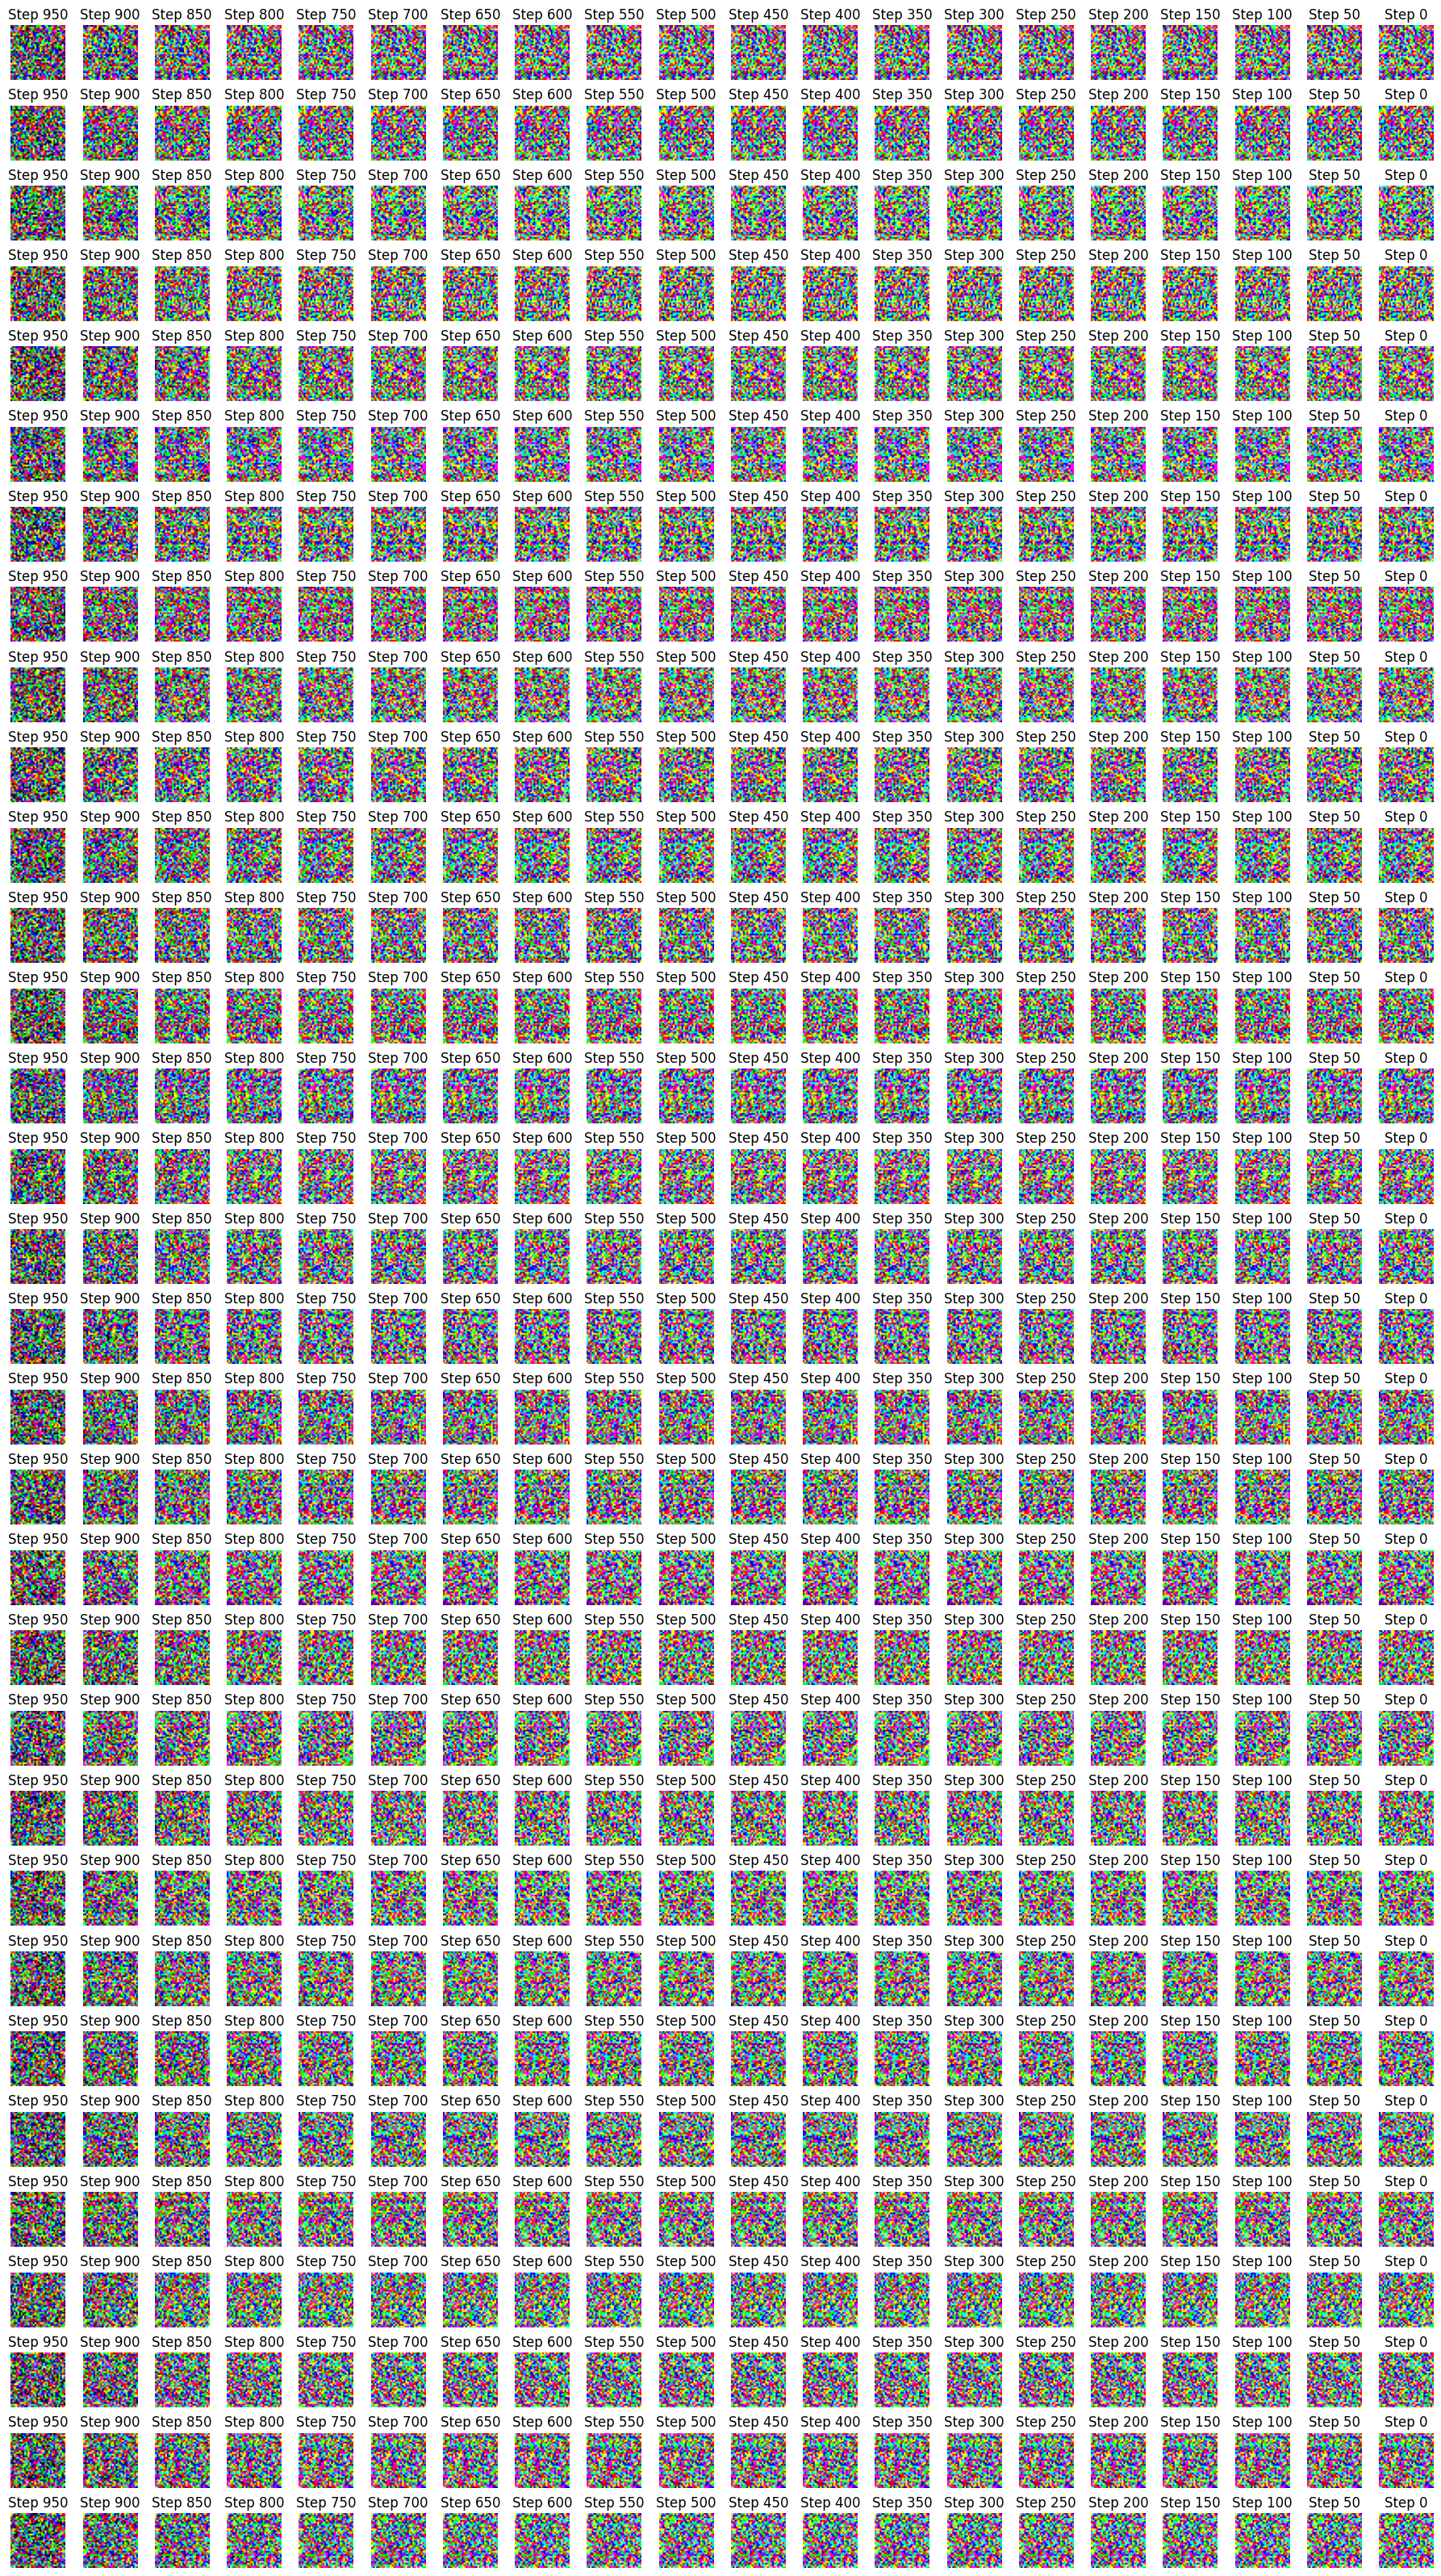

In [7]:
# Plot the selected images as RGB
fig_rgb, axes_rgb = plt.subplots(32, len(img_to_show), figsize=(18, 32))
for idx, (step, imgs) in enumerate(img_to_show):
    for i in range(32):
        img = imgs[i].permute(1, 2, 0).clamp(0, 1).numpy()  # (C, H, W) -> (H, W, C)
        axes_rgb[i, idx].imshow(img)
        axes_rgb[i, idx].set_title(f"Step {step}")
        axes_rgb[i, idx].axis('off')
plt.tight_layout()
plt.show()
